In [55]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


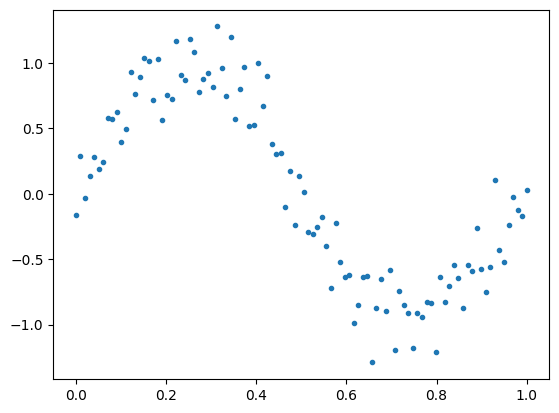

In [50]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
train_v = (torch.randn(train_x.size())*0.1)**2
plt.plot(train_x,train_y,'.')
plt.show()

In [51]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [52]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 0.938   lengthscale: 0.693   noise: 0.693
Iter 2/500 - Loss: 0.935   lengthscale: 0.688   noise: 0.688
Iter 3/500 - Loss: 0.932   lengthscale: 0.683   noise: 0.683
Iter 4/500 - Loss: 0.929   lengthscale: 0.678   noise: 0.678
Iter 5/500 - Loss: 0.926   lengthscale: 0.673   noise: 0.673
Iter 6/500 - Loss: 0.923   lengthscale: 0.668   noise: 0.669
Iter 7/500 - Loss: 0.920   lengthscale: 0.664   noise: 0.664
Iter 8/500 - Loss: 0.917   lengthscale: 0.659   noise: 0.659
Iter 9/500 - Loss: 0.914   lengthscale: 0.654   noise: 0.654
Iter 10/500 - Loss: 0.911   lengthscale: 0.649   noise: 0.649
Iter 11/500 - Loss: 0.907   lengthscale: 0.644   noise: 0.644
Iter 12/500 - Loss: 0.904   lengthscale: 0.639   noise: 0.640
Iter 13/500 - Loss: 0.901   lengthscale: 0.634   noise: 0.635
Iter 14/500 - Loss: 0.898   lengthscale: 0.629   noise: 0.630
Iter 15/500 - Loss: 0.894   lengthscale: 0.625   noise: 0.626
Iter 16/500 - Loss: 0.891   lengthscale: 0.620   noise: 0.621
Iter 17/500 - Los

In [53]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 200)
    observed_pred = likelihood(model(test_x))

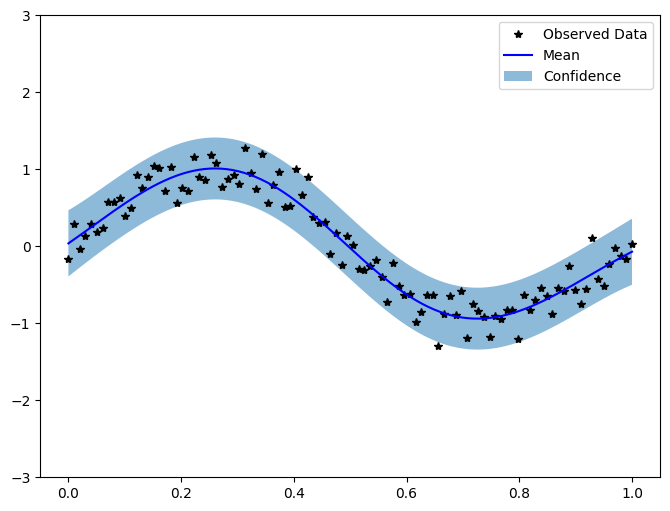

In [54]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

Iter 10/500 - Loss: 0.520
Iter 20/500 - Loss: 0.304
Iter 30/500 - Loss: 0.323
Iter 40/500 - Loss: 0.267
Iter 50/500 - Loss: 0.270
Iter 60/500 - Loss: 0.267
Iter 70/500 - Loss: 0.267
Iter 80/500 - Loss: 0.267
Iter 90/500 - Loss: 0.267
Iter 100/500 - Loss: 0.267
Iter 110/500 - Loss: 0.267
Iter 120/500 - Loss: 0.267
Iter 130/500 - Loss: 0.267
Iter 140/500 - Loss: 0.267
Iter 150/500 - Loss: 0.267
Iter 160/500 - Loss: 0.267
Iter 170/500 - Loss: 0.267
Iter 180/500 - Loss: 0.267
Iter 190/500 - Loss: 0.267
Iter 200/500 - Loss: 0.267
Iter 210/500 - Loss: 0.267
Iter 220/500 - Loss: 0.267
Iter 230/500 - Loss: 0.267
Iter 240/500 - Loss: 0.267
Iter 250/500 - Loss: 0.267
Iter 260/500 - Loss: 0.267
Iter 270/500 - Loss: 0.267
Iter 280/500 - Loss: 0.267
Iter 290/500 - Loss: 0.267
Iter 300/500 - Loss: 0.267
Iter 310/500 - Loss: 0.267
Iter 320/500 - Loss: 0.267
Iter 330/500 - Loss: 0.267
Iter 340/500 - Loss: 0.267
Iter 350/500 - Loss: 0.269
Iter 360/500 - Loss: 0.267
Iter 370/500 - Loss: 0.267
Iter 380/5

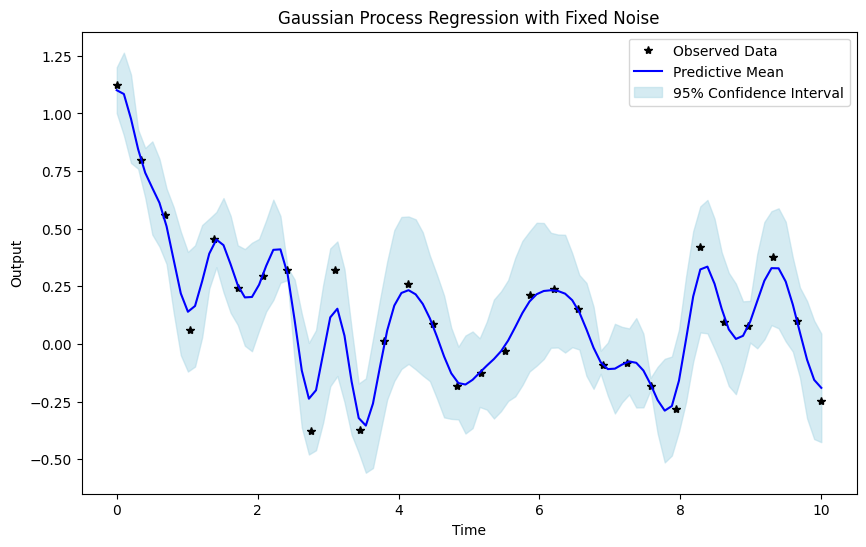

In [49]:
# Step 1: Simulated Data
t = torch.linspace(0, 10, 30)  # 20 time points between 0 and 10
y = torch.exp(-t) + 0.2 * torch.randn(t.size())  # Sinusoidal data with noise
std = 0.2 * torch.rand(t.size())  # Constant uncertainty for simplicity

# Variance for FixedNoiseGaussianLikelihood (square of std deviations)
variance = std ** 2

# Step 2: Define the GP Model
class FixedNoiseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # Define the mean and kernel (covariance function)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Step 3: Use FixedNoiseGaussianLikelihood
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=variance)
model = FixedNoiseGPModel(t, y, likelihood)

# Step 4: Train the Model
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.2)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

training_iterations = 500
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t)
    loss = -mll(output, y)
    loss.backward()
    if (i + 1) % 10 == 0:
        print(f"Iter {i + 1}/{training_iterations} - Loss: {loss.item():.3f}")
    optimizer.step()

# Step 5: Make Predictions
model.eval()
likelihood.eval()

# Test data for predictions
t_test = torch.linspace(0, 10, 100)

# Predictive mean and variance
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = model(t_test)
    pred_mean = pred_dist.mean
    pred_stddev = pred_dist.stddev

# Step 6: Plot Results
plt.figure(figsize=(10, 6))
plt.plot(t, y, 'k*', label='Observed Data')  # Observations
plt.plot(t_test, pred_mean, 'b', label='Predictive Mean')  # GP mean
plt.fill_between(
    t_test.numpy(),
    pred_mean.numpy() - 2 * pred_stddev.numpy(),
    pred_mean.numpy() + 2 * pred_stddev.numpy(),
    color='lightblue',
    alpha=0.5,
    label='95% Confidence Interval',
)
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.title('Gaussian Process Regression with Fixed Noise')
plt.show()


In [82]:
rlx_data = '''
# relaxation from ccsd object using 500 walkers
# rlx_step       system1_en      system2_en      en_diff
    0            -15.922150      -15.901495      -0.020656
# relaxation time: 4.92
'''

prop_data = '''
# multiple independent post relaxation propagation with step size 0.01s
# correlated sampling
# tot_walkers: 750, propagation steps: 30, number of independent runs: 200
# step   system1_en      error           system2_en      error           energy_diff     error
  1      -15.921831      0.000001        -15.900984      0.000002        -0.020847       0.000001
  2      -15.921867      0.000004        -15.900894      0.000005        -0.020973       0.000004
  3      -15.922008      0.000006        -15.900944      0.000008        -0.021064       0.000006
  4      -15.922162      0.000009        -15.901025      0.000012        -0.021137       0.000009
  5      -15.922293      0.000013        -15.901140      0.000017        -0.021153       0.000013
  6      -15.922428      0.000019        -15.901218      0.000017        -0.021210       0.000013
  7      -15.922484      0.000017        -15.901243      0.000019        -0.021241       0.000015
  8      -15.922584      0.000025        -15.901328      0.000031        -0.021256       0.000025
  9      -15.922590      0.000019        -15.901323      0.000026        -0.021267       0.000019
  10     -15.922667      0.000028        -15.901358      0.000025        -0.021309       0.000029
  11     -15.922656      0.000016        -15.901347      0.000023        -0.021308       0.000020
  12     -15.922697      0.000029        -15.901386      0.000032        -0.021310       0.000026
  13     -15.922662      0.000024        -15.901319      0.000028        -0.021342       0.000027
  14     -15.922654      0.000019        -15.901319      0.000029        -0.021335       0.000025
  15     -15.922694      0.000019        -15.901338      0.000026        -0.021356       0.000023
  16     -15.922729      0.000021        -15.901434      0.000032        -0.021295       0.000029
  17     -15.922720      0.000022        -15.901418      0.000030        -0.021302       0.000026
  18     -15.922706      0.000024        -15.901424      0.000035        -0.021281       0.000032
  19     -15.922749      0.000028        -15.901371      0.000031        -0.021379       0.000028
  20     -15.922750      0.000025        -15.901434      0.000031        -0.021316       0.000029
  21     -15.922743      0.000023        -15.901448      0.000036        -0.021294       0.000034
  22     -15.922742      0.000024        -15.901430      0.000031        -0.021312       0.000031
  23     -15.922785      0.000026        -15.901507      0.000033        -0.021278       0.000032
  24     -15.922746      0.000024        -15.901492      0.000033        -0.021254       0.000032
  25     -15.922735      0.000024        -15.901467      0.000037        -0.021268       0.000036
  26     -15.922757      0.000027        -15.901492      0.000035        -0.021265       0.000036
  27     -15.922752      0.000027        -15.901462      0.000035        -0.021291       0.000035
  28     -15.922741      0.000027        -15.901487      0.000033        -0.021254       0.000038
  29     -15.922793      0.000032        -15.901507      0.000034        -0.021286       0.000037
  30     -15.922770      0.000024        -15.901471      0.000035        -0.021299       0.000037
# total run time: 1940.78    
'''

rlx_en_diff = []
lines = rlx_data.splitlines()
for line in lines:
    if not line.startswith("#"): 
        columns = line.split()
        if len(columns) > 3:
            rlx_en_diff.append(columns[3])

rlx_en_diff = np.array(rlx_en_diff,dtype='float32')

prop_en_diff = []
prop_en_diff_err = []
lines = prop_data.splitlines()
for line in lines:
    if not line.startswith("#"): 
        columns = line.split()
        if len(columns) > 5:
            prop_en_diff.append(columns[5])
        if len(columns) > 6:
            prop_en_diff_err.append(columns[6])

prop_en_diff = np.array(prop_en_diff,dtype='float32')
prop_en_diff_err = np.array(prop_en_diff_err,dtype='float32')

rlx_steps = np.arange(len(rlx_en_diff))
prop_steps = np.arange(len(rlx_en_diff),len(rlx_en_diff)+len(prop_en_diff))

In [101]:
rhf_en = -0.026160854776808407*627.509608
ccsd_en = -0.020655769530986134*627.509608
ccsd_t_en = -0.02103714707363765*627.509608
fci_en = -0.021511657203706847*627.509608
rhf_en = torch.tensor([rhf_en]*100)
ccsd_en = torch.tensor([ccsd_en]*100)
ccsd_t_en = torch.tensor([ccsd_t_en]*100)
fci_en = torch.tensor([fci_en]*100)

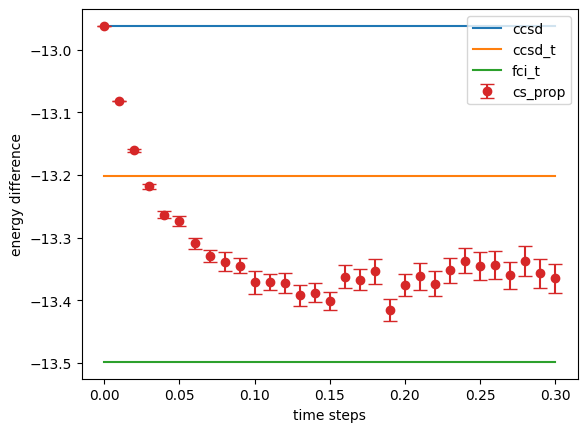

In [103]:
y_data = np.hstack((rlx_en_diff,prop_en_diff))*627.509608
y_std = np.hstack(([0],prop_en_diff_err))*627.509608
x_data = np.arange(len(y_data))*0.01
# y_data = prop_en_diff*627.509608
# y_std = prop_en_diff_err*627.509608
# x_data = np.arange(len(y_data))*0.01+0.01

plt.plot(torch.linspace(0,max(x_data),len(ccsd_en)),ccsd_en,label='ccsd')
plt.plot(torch.linspace(0,max(x_data),len(ccsd_t_en)),ccsd_t_en,label='ccsd_t')
plt.plot(torch.linspace(0,max(x_data),len(fci_en)),fci_en,label='fci_t')
plt.errorbar(x_data,y_data,yerr=y_std, fmt='o', capsize=5,label='cs_prop')
plt.xlabel('time steps')
plt.ylabel('energy difference')
plt.legend()
plt.show()

In [117]:
# x = torch.from_numpy(x_data[:30])
# y = torch.from_numpy(y_data[:30])
# std = torch.from_numpy(y_std[:30])
x = torch.from_numpy(x_data)
y = torch.from_numpy(y_data)
std = torch.from_numpy(y_std)
x = x.to(torch.float32)
y = y.to(torch.float32)
std = std.to(torch.float32)
# print(x.size())
# print(y.size())
# print(std.size())

/home/yichi/research/software/miniconda3/envs/pyscf_afqmc/lib/python3.10/site-packages/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(


Iter 10/500 - Loss: 0.362
Iter 20/500 - Loss: -0.960
Iter 30/500 - Loss: -1.498
Iter 40/500 - Loss: -1.657
Iter 50/500 - Loss: -1.770
Iter 60/500 - Loss: -1.838
Iter 70/500 - Loss: -1.879
Iter 80/500 - Loss: -1.907
Iter 90/500 - Loss: -1.926
Iter 100/500 - Loss: -1.940
Iter 110/500 - Loss: -1.951
Iter 120/500 - Loss: -1.957
Iter 130/500 - Loss: -1.962
Iter 140/500 - Loss: -1.965
Iter 150/500 - Loss: -1.967
Iter 160/500 - Loss: -1.969
Iter 170/500 - Loss: -1.969
Iter 180/500 - Loss: -1.970
Iter 190/500 - Loss: -1.969
Iter 200/500 - Loss: -1.970
Iter 210/500 - Loss: -1.971
Iter 220/500 - Loss: -1.971
Iter 230/500 - Loss: -1.971
Iter 240/500 - Loss: -1.972
Iter 250/500 - Loss: -1.971
Iter 260/500 - Loss: -1.972
Iter 270/500 - Loss: -1.973
Iter 280/500 - Loss: -1.972
Iter 290/500 - Loss: -1.973
Iter 300/500 - Loss: -1.973
Iter 310/500 - Loss: -1.973
Iter 320/500 - Loss: -1.973
Iter 330/500 - Loss: -1.974
Iter 340/500 - Loss: -1.973
Iter 350/500 - Loss: -1.974
Iter 360/500 - Loss: -1.974
It

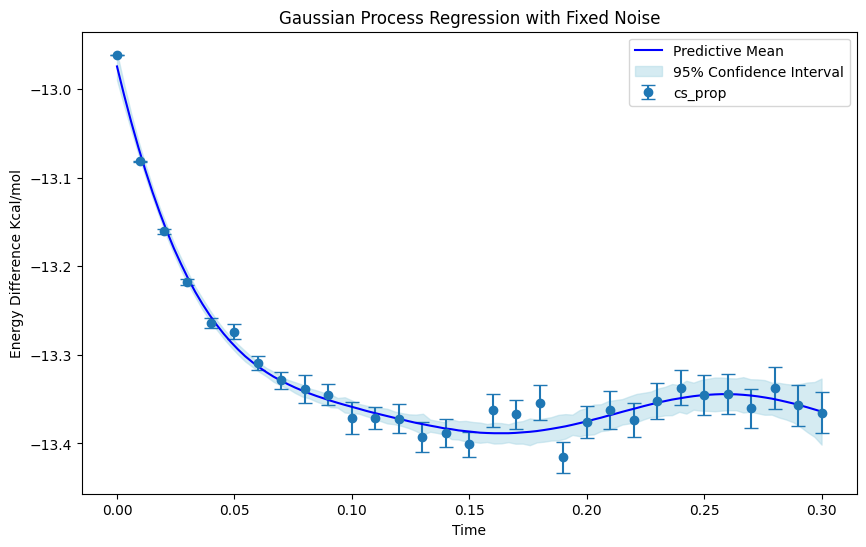

In [ ]:
# # Step 1: Simulated Data
# t = torch.linspace(0, 10, 30)  # 20 time points between 0 and 10
# y = torch.exp(-t) + 0.2 * torch.randn(t.size())  # Sinusoidal data with noise
# std = 0.2 * torch.rand(t.size())  # Constant uncertainty for simplicity

# Variance for FixedNoiseGaussianLikelihood (square of std deviations)
variance = std ** 2

# Step 2: Define the GP Model
class FixedNoiseGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # Define the mean and kernel (covariance function)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Step 3: Use FixedNoiseGaussianLikelihood
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=variance)
model = FixedNoiseGPModel(x, y, likelihood)

# Step 4: Train the Model
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.2)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

training_iterations = 500
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(x)
    loss = -mll(output, y)
    loss.backward()
    if (i + 1) % 10 == 0:
        print(f"Iter {i + 1}/{training_iterations} - Loss: {loss.item():.3f}")
    optimizer.step()

# Step 5: Make Predictions
model.eval()
likelihood.eval()

# Test data for predictions
x_test = torch.linspace(0, max(x), 100)

# Predictive mean and variance
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = model(x_test)
    pred_mean = pred_dist.mean
    pred_stddev = pred_dist.stddev

# Step 6: Plot Results
plt.figure(figsize=(10, 6))
# plt.plot(x, y, 'k*', label='Observed Data')
plt.errorbar(x,y,yerr=std, fmt='o', capsize=5,label='cs_prop')  # Observations
plt.plot(x_test, pred_mean, 'b', label='Predictive Mean')  # GP mean
plt.fill_between(
    x_test.numpy(),
    pred_mean.numpy() - 2 * pred_stddev.numpy(),
    pred_mean.numpy() + 2 * pred_stddev.numpy(),
    color='lightblue',
    alpha=0.5,
    label='95% Confidence Interval',
)
plt.xlabel('Time')
plt.ylabel('Energy Difference Kcal/mol')
plt.legend()
plt.title('GP Regression Fit')
plt.show()

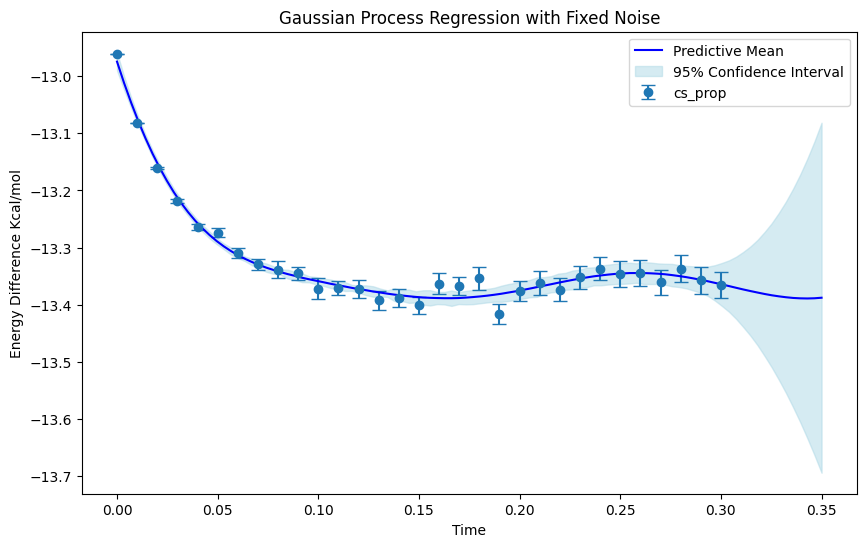

In [ ]:
x_test = torch.linspace(0, max(x)+0.05, 100)

# Predictive mean and variance
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = model(x_test)
    pred_mean = pred_dist.mean
    pred_stddev = pred_dist.stddev

# Step 6: Plot Results
plt.figure(figsize=(10, 6))
# plt.plot(x, y, 'k*', label='Observed Data')
plt.errorbar(x,y,yerr=std, fmt='o', capsize=5,label='cs_prop')  # Observations
plt.plot(x_test, pred_mean, 'b', label='Predictive Mean')  # GP mean
plt.fill_between(
    x_test.numpy(),
    pred_mean.numpy() - 2 * pred_stddev.numpy(),
    pred_mean.numpy() + 2 * pred_stddev.numpy(),
    color='lightblue',
    alpha=0.5,
    label='95% Confidence Interval',
)
plt.xlabel('Time')
plt.ylabel('Energy Difference Kcal/mol')
plt.legend()
plt.title('GP Regression Fit')
plt.show()